# First, calculate the loading from the tributaries.

Time is from 2018-05-01 to 2018-10-01

In [1]:
import pandas as pd
import numpy as np

In [2]:
#Preprocess the data

## read data
Cuyahoga_origin = pd.read_csv('Tributary data/cuyahoga data.csv', encoding = 'utf-8')
Maumee_origin = pd.read_csv('Tributary data/maumeedata.csv')
Portage_origin = pd.read_csv('Tributary data/portagedata.csv')
Sandusky_origin = pd.read_csv('Tributary data/sanduskydata.csv')

def redate(Cuyahoga_origin):
    # Trnasform the datetime col to daily
    Cuyahoga_origin['Datetime (date and time of sample collection)'] = pd.to_datetime(Cuyahoga_origin['Datetime (date and time of sample collection)'])
    Cuyahoga_origin['Datetime (date and time of sample collection)'] = Cuyahoga_origin['Datetime (date and time of sample collection)'].dt.date
    
    # Gourp each day, 
    Cuyahoga_origin = Cuyahoga_origin.groupby(Cuyahoga_origin['Datetime (date and time of sample collection)']).mean()
    
    # Select 2018 data
    daterange = pd.date_range('2018-05-01', '2018-10-01')
    Cuyahoga_origin = Cuyahoga_origin.reindex(daterange)
    
    Cuyahoga_origin = Cuyahoga_origin.iloc[:,[2,4,7]]
    
    Cuyahoga_origin.columns = ['Flow','TP','TKN']
    
    Cuyahoga_origin['Flow'] = Cuyahoga_origin['Flow'] * 0.3048 ** 3 * 24 * 3600# Transform into m3/d
    
    return Cuyahoga_origin
    
    
Cuyahoga_origin = redate(Cuyahoga_origin)
Maumee_origin = redate(Maumee_origin)
Portage_origin = redate(Portage_origin)
Sandusky_origin = redate(Sandusky_origin)

# Interpolate
Cuyahoga_origin.loc['2018-10-01'] = [1000* 0.3048 ** 3 * 24 * 3600, 0.11, 0.74]
Cuyahoga = Cuyahoga_origin.interpolate(method='polynomial', order = 2)
Maumee = Maumee_origin.interpolate(method='polynomial', order = 2)
Portage = Portage_origin.interpolate(method='polynomial', order = 2)
Sandusky = Sandusky_origin.interpolate(method='polynomial', order = 2)

In [3]:
# Preprocess the data 2
Main = pd.read_csv('Tributary data/Main Discharge.csv', index_col = 0, parse_dates = True)
Detroit = Main.loc[pd.date_range('2018-05-01', '2018-10-01'),['Detroit']] * 24 * 3600
Nigara = Main.loc[pd.date_range('2018-05-01', '2018-10-01'),['Nigara']] * 24 * 3600

In [4]:
Detroit['TP'] = Maumee['TP']
Detroit['TKN'] = Maumee['TKN']

Nigara['TP'] = Cuyahoga['TP']
Nigara['TKN'] = Cuyahoga['TKN']

In [5]:
Detroit.columns = ['Flow','TP','TKN']
Nigara.columns = ['Flow','TP','TKN']

# Read Lake Water quality data to get light and temperature series

In [6]:
lakewq = pd.read_csv('lakeWQ2018.csv', index_col=0, parse_dates=True)

In [7]:
# Aquire the average tem and light intensity of the lake erie
WatTem = lakewq.groupby(lakewq.index).mean().loc[:,['Temperature']]
Light = lakewq.groupby(lakewq.index).mean().loc[:,['Light Intensity']]


WatTem = WatTem.reindex(pd.date_range('2018-05-01', '2018-10-01'))
WatTem.loc['2018-05-01'] = 17.1
WatTem.loc['2018-10-01'] = 19.1
WatTem = WatTem.interpolate(method='polynomial', order = 2)

Light = Light.reindex(pd.date_range('2018-05-01', '2018-10-01'))
Light.loc['2018-05-01'] = 100
Light.loc['2018-10-01'] = 334.125
Light = Light.interpolate(method='polynomial', order = 2)

# Assign chl-a for each tributaries by lake monitoring data

In [8]:
def get_chl(WE):# Input the site number
    chl = lakewq.loc[lakewq.loc[:,'Site'] == WE]
    chl = chl.reindex(pd.date_range('2018-05-01', '2018-10-01'))
    chl.loc['2018-05-01'] = 12
    chl = chl.interpolate(method='polynomial', order = 2)
    return chl['chl-a']
# Trnasform into mg/L
Detroit['chla'] = get_chl('WE6') * 0.001
Maumee['chla'] = get_chl('WE6') * 0.001
Portage['chla'] = get_chl('WE16') * 0.001
Sandusky['chla'] = get_chl('WE2') * 0.001
Cuyahoga['chla'] = get_chl('WE13') * 0.001
Nigara['chla'] = get_chl('WE8') * 0.001

In [9]:
lakewq.groupby(lakewq['Site']).mean()

,Temperature,Light Intensity,chl-a,TP,TKN
Site,,,,,
WE12,23.556250,568.687500,14.645882,0.048706,0.245933
WE13,23.671429,485.500000,10.636000,0.034666,0.203064
WE16,23.814286,579.071429,14.354000,0.031094,0.232948
WE2,23.825000,692.312500,15.104706,0.049653,0.277926
WE4,23.181250,335.812500,11.260000,0.028511,0.206946
WE6,23.433333,356.000000,32.060000,0.084462,0.445602
WE8,23.437500,178.437500,22.205882,0.046543,0.302109
WE9,23.450000,307.055556,30.747222,0.125169,0.499221


# Calculate the loading(inflow - outflow). g/d

In [10]:
def cal_loading(WQ): #input the parameter name,'TP','TKN','chla'
    W_in = 0
    for inflow in [Detroit, Maumee, Portage, Sandusky, Cuyahoga]:
        W_in = inflow['Flow'] * inflow[WQ] + W_in
    W_out = Nigara['Flow'] * Nigara[WQ]
    W = W_in * 2 - W_out
    return W

In [11]:
W_tkn = cal_loading('TKN')
W_tp = cal_loading('TP')
W_chla = cal_loading('chla')

# Build the differential equation

In [12]:
#import odeint to solve the ode
from scipy.integrate import solve_ivp

In [13]:
import matplotlib.pyplot as plt

In [14]:
Parameters = pd.read_csv('Parameters.csv', index_col=0)
Parameters

,umax,Topt,kl,ksn,ksp,dn,dp,upt_n_max,upt_p_max,rmax,dchl
Parameter,,,,,,,,,,,
Description,Maximum growth rate of chl-a,Optimal Temperature for algal growth,Half Saturation Light Intensity of algal growth,Half Saturation nitrogen concentration of alga...,Half Saturation phosphrus concentration of alg...,Loss rate of nitrogen,Loss rate of phosphrus,Maximum Uptake rate of nitrogen,Maximum Uptake rate of phosphrus,Maximum Death rate of algae,Loss rate of chl-a
unit,/d,C,uE/(m2/s),mg/L,mg/L,/d,/d,/d,/d,/d,/d
min,1,25,250,0.1,0.001,0.01,0.01,0.01,0.01,0,0
max,3,35,350,0.25,0.05,0.05,0.1,0.1,0.1,2,1
Value,1.25,29.5,295,0.22,0.015,0.03,0.02,0.05,0.048,1,0.48


In [15]:
%%time
Parameters = pd.read_csv('Parameters.csv', index_col=0)
V = pd.read_csv('V_Erie.csv', index_col = 0, parse_dates=True).reindex(pd.date_range('2018-05-01', '2018-10-01'))['V/km3']*100000000
para_values = Parameters.loc['Value',:].astype('float')

def conc_change(t, w, *args):
    # loading, temp and light, and model parameters are passed into the function
    W_tp, W_tkn, W_chla, T, Light, V, para_values = args
    
    # initial value of each indicators
    N,P,Chl = w
    
    # read all the parameters
    umax, Topt, kl, ksn, ksp, dn, dp, upt_n_max, upt_p_max, Rmax, dchl = para_values
    
    
    # The limitation of N and P
    Fnp = 2/(N/(ksn + N) + P/(ksp + P))
    Fn = N/(ksn+N)
    Fp = P/(ksp+P)
    
    
    # The limitation of Light and Temperature
    
    Fl = Light[int(t)]/(Light[int(t)] + kl)
    
    Ft = np.exp(-2.3/15 * np.abs(T[int(t)] - Topt))
    
    
    # Growth of algae
    u = umax * Fl * Fnp
    
    # Death rate of chl
    R = Rmax * Ft * Fnp
    
    # uptake
    upt_n = upt_n_max * Fn
    upt_p = upt_p_max * Fp
    
    # func of variation of N and P
    S_n = W_tkn[int(t)]/V[int(t)] - dn * N - upt_n * N
    S_p = W_tp[int(t)]/V[int(t)] - dp * P - upt_p * P
    S_chl = W_chla[int(t)]/V[int(t)] - R * Chl + u * Chl - dchl * Chl
    
    return S_n, S_p, S_chl


result = solve_ivp(conc_change, (0,153), [0.2,0.10,0.01],  method = 'RK45', t_eval = [i for i in range(153)], args = (W_tp.values, W_tkn.values, W_chla.values, WatTem.values, Light.values, V.values, para_values))

N,P,chl = result.y

Wall time: 61.8 ms


# Result Visualization

## First, present the loading

In [16]:
import matplotlib.pyplot as plt

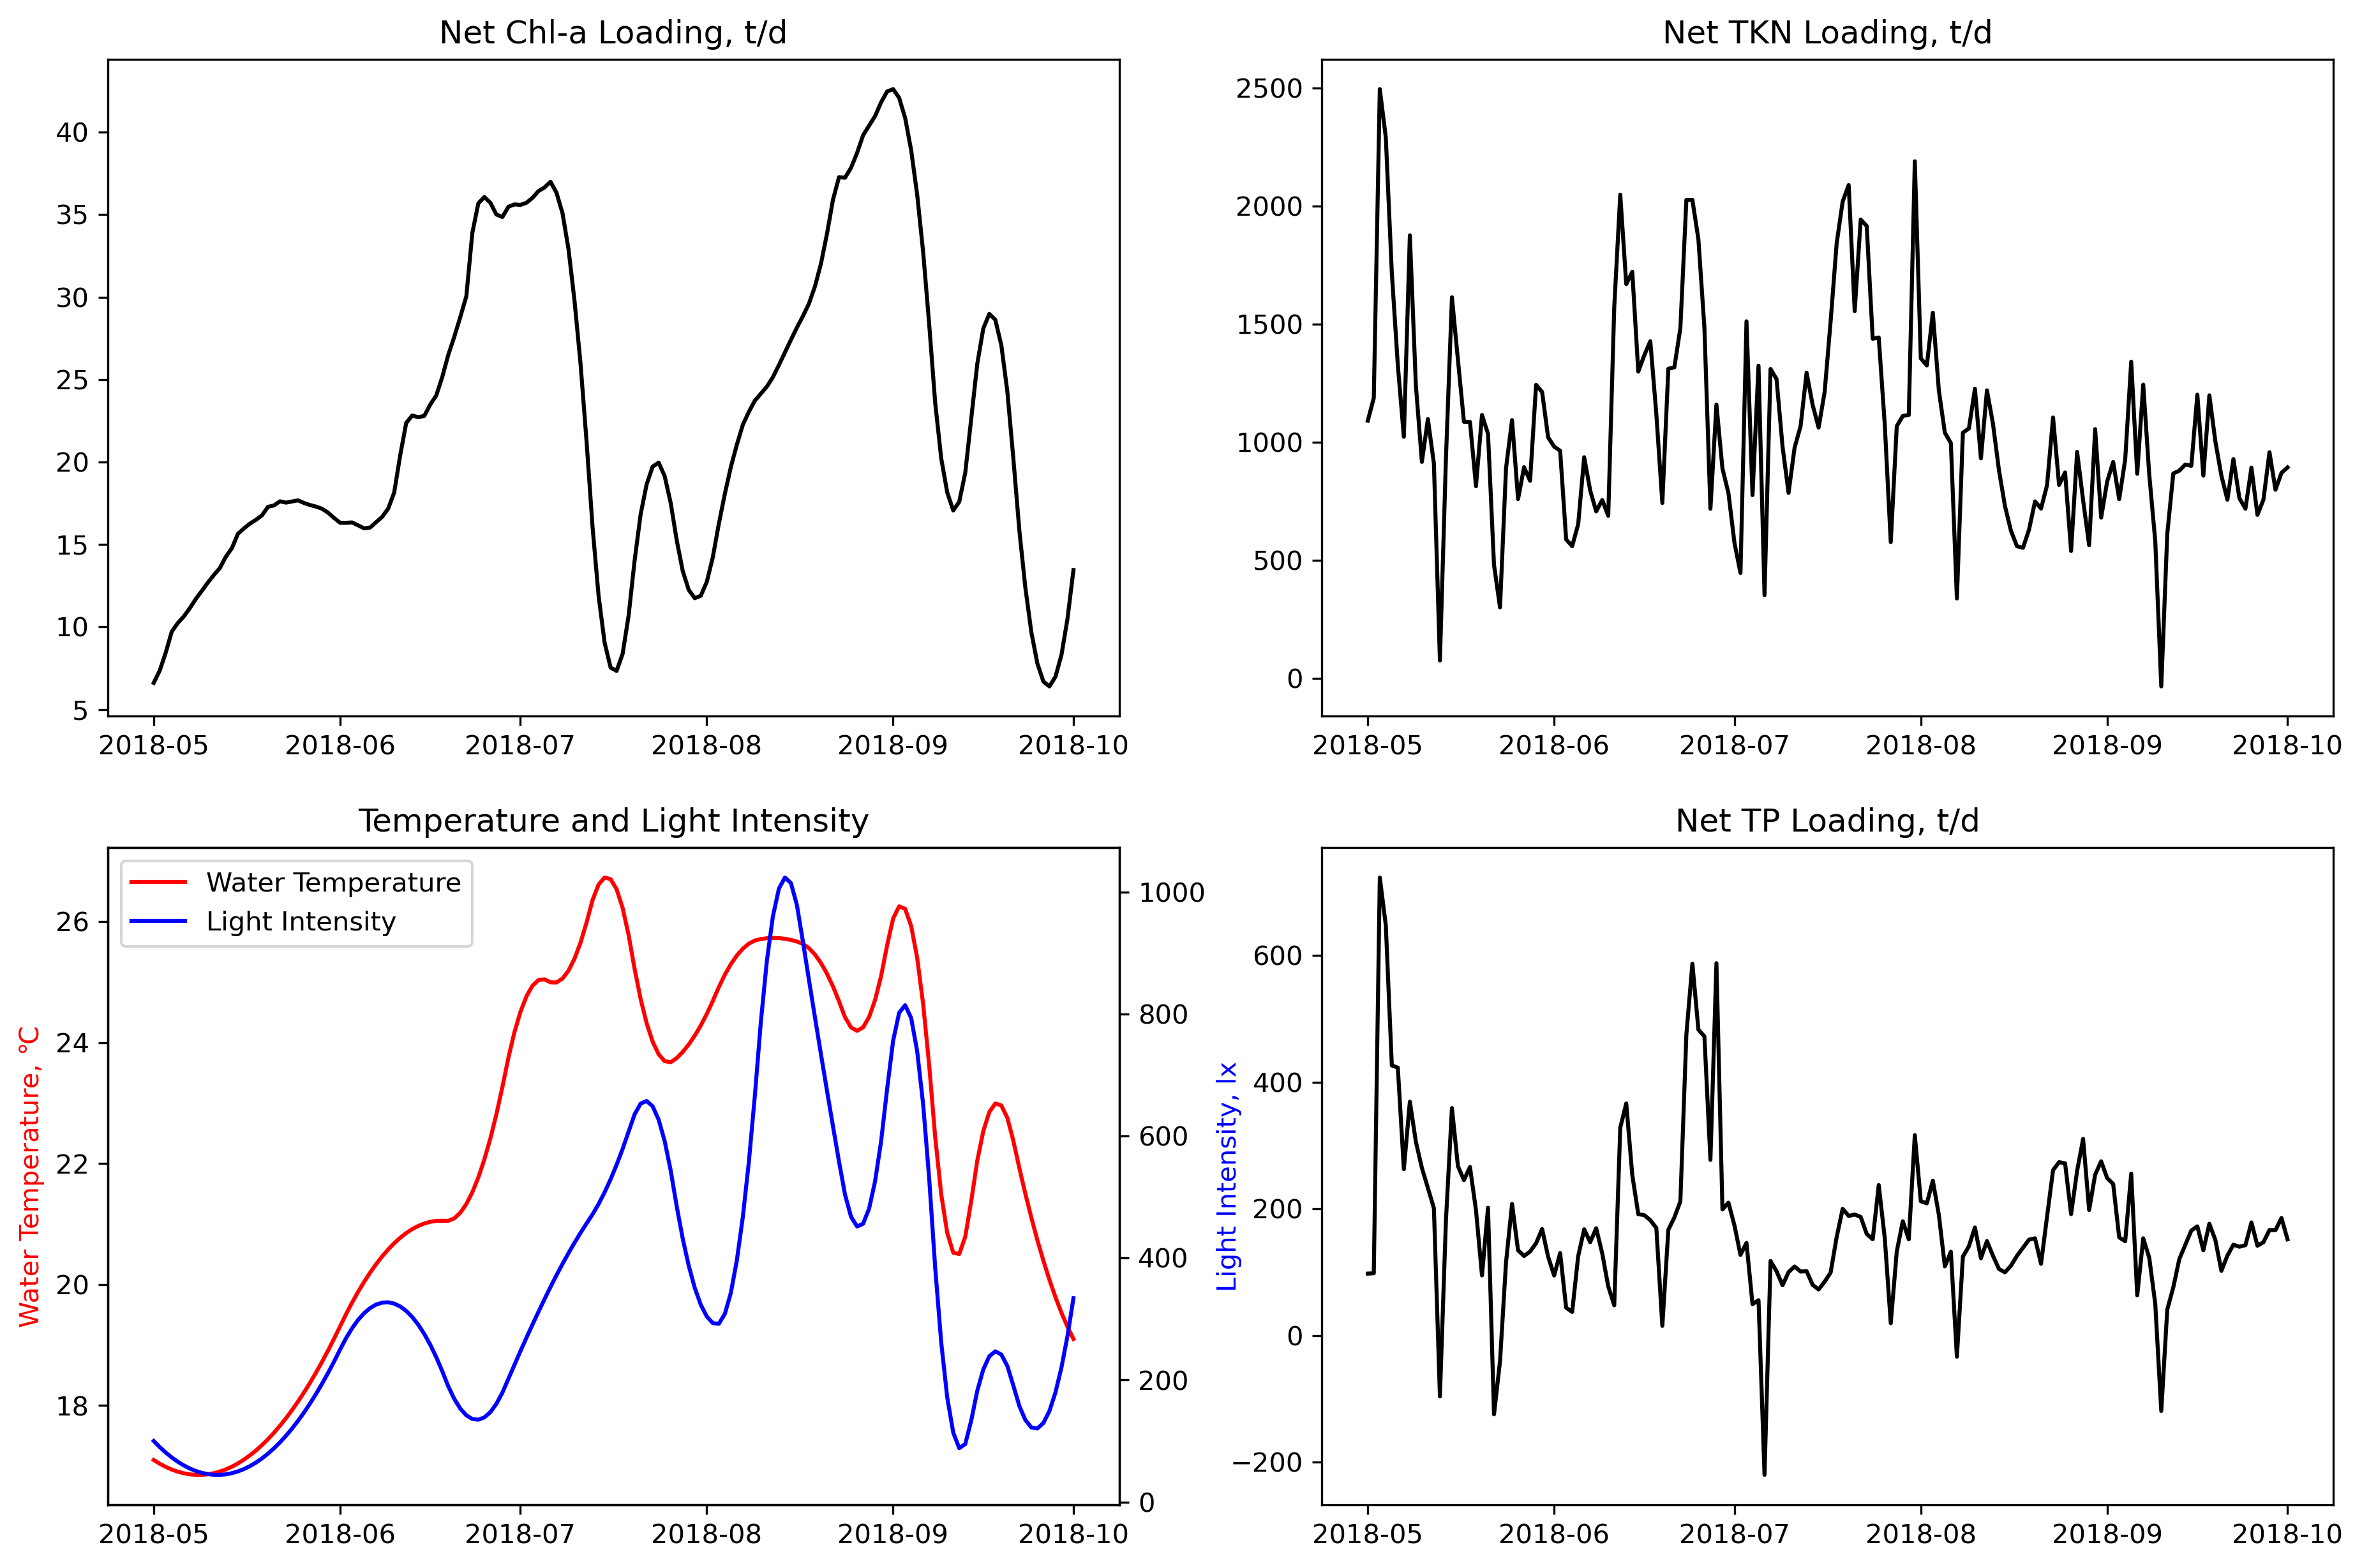

In [17]:
fig,axes = plt.subplots(2,2, figsize = (15,10), dpi = 300)

axes[0][0].plot(pd.date_range('2018-05-01','2018-10-01'), W_chla.values/1000000, color = 'black')
axes[0][0].set_title('Net Chl-a Loading, t/d')

axes[0][1].plot(pd.date_range('2018-05-01','2018-10-01'), W_tkn.values/1000000, color = 'black')
axes[0][1].set_title('Net TKN Loading, t/d')

axes[1][1].plot(pd.date_range('2018-05-01','2018-10-01'), W_tp.values/1000000, color = 'black')
axes[1][1].set_title('Net TP Loading, t/d')

l1 = axes[1][0].plot(pd.date_range('2018-05-01','2018-10-01'), WatTem, color = 'red')
axes[1][0].set_ylabel('Water Temperature, ℃',color = 'red')

ax = axes[1][0].twinx()
l2 = ax.plot(pd.date_range('2018-05-01','2018-10-01'), Light, color = 'blue')
ax.set_ylabel('Light Intensity, lx',color = 'blue')

axes[1][0].legend(l1+l2, ['Water Temperature','Light Intensity'])
axes[1][0].set_title('Temperature and Light Intensity')

fig.savefig('Loadings,tem,light.png')

## Present the results

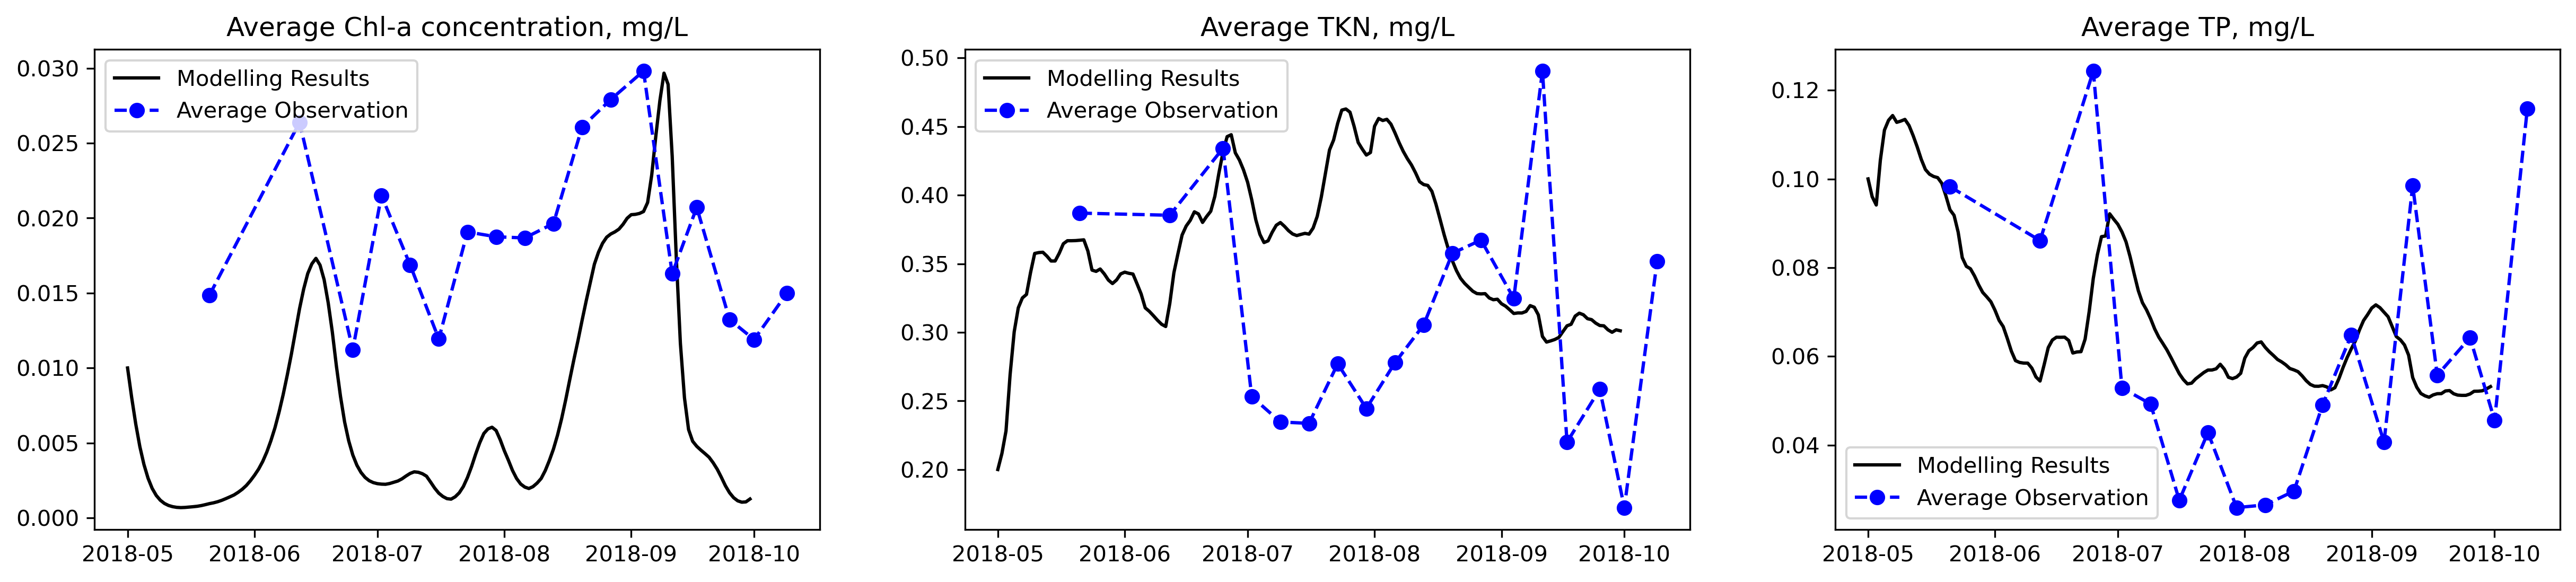

In [18]:
fig,axes = plt.subplots(1,3, figsize = (20,4), dpi = 300)

# model results
chl_df = pd.DataFrame(chl, index = pd.date_range('2018-05-01', '2018-09-30'), columns=['chl-a, mg/L']).reindex(pd.date_range('2018-05-01', '2018-10-01'))
TN_df = pd.DataFrame(N, index = pd.date_range('2018-05-01', '2018-09-30'), columns=['TKN, mg/L']).reindex(pd.date_range('2018-05-01', '2018-10-01'))
TP_df = pd.DataFrame(P, index = pd.date_range('2018-05-01', '2018-09-30'), columns=['TP, mg/L']).reindex(pd.date_range('2018-05-01', '2018-10-01'))

# monitoring results
av_chla = lakewq.groupby(lakewq.index).mean()['chl-a']
av_tkn = lakewq.groupby(lakewq.index).mean()['TKN']
av_tp = lakewq.groupby(lakewq.index).mean()['TP']


axes[0].plot(pd.date_range('2018-05-01','2018-10-01'), chl_df.values, color = 'black' ,label = 'Modelling Results')
axes[0].plot(av_chla.index, av_chla.values/1000, 'bo--', label = 'Average Observation')
axes[0].set_title('Average Chl-a concentration, mg/L')
axes[0].legend()

axes[1].plot(pd.date_range('2018-05-01','2018-10-01'), TN_df.values, color = 'black' ,label = 'Modelling Results')
axes[1].plot(av_tkn.index, av_tkn.values,'bo--', label = 'Average Observation')
axes[1].set_title('Average TKN, mg/L')
axes[1].legend()

axes[2].plot(pd.date_range('2018-05-01','2018-10-01'), TP_df.values, color = 'black' ,label = 'Modelling Results')
axes[2].plot(av_tp.index, av_tp.values,'bo--' ,label = 'Average Observation')
axes[2].set_title('Average TP, mg/L')
axes[2].legend()

fig.savefig('Model Results.png')

In [19]:
lakewq.groupby(lakewq.index).mean()

,Temperature,Light Intensity,chl-a,TP,TKN
Date,,,,,
2018-05-21,17.550000,88.000000,14.858750,0.098241,0.386875
2018-06-12,20.850000,313.250000,26.390000,0.086101,0.385315
2018-06-25,22.066667,138.666667,11.218333,0.124318,0.434187
2018-07-02,24.762500,269.250000,21.515000,0.052868,0.253162
2018-07-09,25.187500,408.125000,16.875000,0.049263,0.234660
2018-07-16,26.700000,529.125000,11.938750,0.027535,0.233639
2018-07-23,24.012500,648.625000,19.076250,0.042826,0.277094
2018-07-30,24.112500,351.125000,18.752500,0.025890,0.244514
2018-08-06,25.437500,395.875000,18.675000,0.026499,0.277905


In [20]:
Detroit

,Flow,TP,TKN,chla
2018-05-01,5.858487e+08,0.112000,1.335000,0.012000
2018-05-02,5.821680e+08,0.110000,1.386000,0.011764
2018-05-03,5.778326e+08,0.682000,2.438000,0.011591
2018-05-04,5.737869e+08,0.570333,2.107000,0.011481
2018-05-05,5.701884e+08,0.384000,1.776000,0.011435
...,...,...,...,...
2018-09-27,5.746441e+08,0.154000,0.975000,0.014479
2018-09-28,5.776993e+08,0.173000,1.113000,0.014484
2018-09-29,5.802048e+08,0.178000,0.963000,0.015193
2018-09-30,5.821609e+08,0.201000,1.072000,0.016605


# Calculate the Nash coefficient to evaluate

$$
Nash = 1 - \frac{ \sum_{i}^{n} (OBS_i - SIM_i)^2} {\sum_{i}^{n} (OBS_i - \overline{OBS})^2}
$$

In [21]:
obs = lakewq.groupby(lakewq.index).mean().loc[:,['chl-a','TKN','TP']]
# monitoring results average
av_chla = lakewq.groupby(lakewq.index).mean()['chl-a']
av_tkn = lakewq.groupby(lakewq.index).mean()['TKN']
av_tp = lakewq.groupby(lakewq.index).mean()['TP']

In [22]:
def cal_nse(av_chla, chl_df):
    # for chl-a
    av_chl = av_chla.iloc[:-1]
    sim_chl = chl_df.loc[av_chl.index[:-1]]
    sim_chl.loc['2018-10-01'] = chl_df.loc['2018-09-30']

    # transform into arrays
    obs_chl = av_chl.values
    sim_chl = sim_chl.values.flatten()

    nse = 1 - np.sum((obs_chl - sim_chl)**2)/np.sum((obs_chl - np.mean(obs_chl))**2)
    return nse

In [23]:
nse_chl = cal_nse(av_chla/1000, chl_df)
print(nse_chl)

-4.438505159333418


In [24]:
nse_tkn = cal_nse(av_tkn, TN_df)
print(nse_tkn)

-1.0127192114241774


In [25]:
nse_tp = cal_nse(av_tp, TP_df)
print(nse_tp)

0.11061197740957307


# Calibrate the model

## First, wrap the simulation and assessment into one function

In [26]:
# Reread the observation results
obs = lakewq.groupby(lakewq.index).mean().loc[:,['chl-a','TKN','TP']]
# monitoring results average
av_chla = lakewq.groupby(lakewq.index).mean()['chl-a']
av_tkn = lakewq.groupby(lakewq.index).mean()['TKN']
av_tp = lakewq.groupby(lakewq.index).mean()['TP']
av_obs = (av_chla, av_tkn, av_tp)

In [27]:
def sim_cal_nse(para_values):# para_values should be （11,）
    # unpack the data
    # W_tp, W_tkn, W_chla = loading
    # av_chla, av_tkn, av_tp = av_obs
    global W_tp, W_tkn, W_chla, WatTem, Light, V
    global av_chla, av_tkn, av_tp
    
    
    # Simulate, get results
    result = solve_ivp(conc_change, (0,153), [0.2,0.10,0.01],  method = 'RK45', t_eval = [i for i in range(153)], args = (W_tp.values, W_tkn.values, W_chla.values, WatTem.values, Light.values, V.values, para_values))
    N, P, chl = result.y
    
    # make the results be a dataframe with time ranges
    chl_df = pd.DataFrame(chl, index = pd.date_range('2018-05-01', '2018-09-30'), columns=['chl-a, mg/L']).reindex(pd.date_range('2018-05-01', '2018-10-01'))
    tkn_df = pd.DataFrame(N, index = pd.date_range('2018-05-01', '2018-09-30'), columns=['TKN, mg/L']).reindex(pd.date_range('2018-05-01', '2018-10-01'))
    tp_df = pd.DataFrame(P, index = pd.date_range('2018-05-01', '2018-09-30'), columns=['TP, mg/L']).reindex(pd.date_range('2018-05-01', '2018-10-01'))
    
    # Calculathe the nse for each varibles
    chl_nse = cal_nse(av_chla/1000, chl_df)
    tkn_nse = cal_nse(av_tkn, tkn_df)
    tp_nse = cal_nse(av_tp, tp_df)
    
    # Define a overall_nse, put more weights on chla
    # score = (4*chl_nse + tkn_nse + tp_nse)/6
    
    return 1-chl_nse

In [28]:
para_values = Parameters.loc['Value',:].astype('float')
para_values

umax           1.250
Topt          29.500
kl           295.000
ksn            0.220
ksp            0.015
dn             0.030
dp             0.020
upt_n_max      0.050
upt_p_max      0.048
rmax           1.000
dchl           0.480
Name: Value, dtype: float64

In [29]:
%%time
sim_cal_nse(para_values)

Wall time: 41.9 ms


5.438505159333418

## Test each parameter sensitivity

In [30]:
Parameters = pd.read_csv('Parameters.csv', index_col=0)
para_values = Parameters.loc['Value',:].astype('float')
para_values

umax           1.250
Topt          29.500
kl           295.000
ksn            0.220
ksp            0.015
dn             0.030
dp             0.020
upt_n_max      0.050
upt_p_max      0.048
rmax           1.000
dchl           0.480
Name: Value, dtype: float64

In [31]:
# test performance
def plot_score(para_name, min_para, max_para, num_para):    
    score = np.zeros(num_para)
    para = np.linspace(min_para, max_para, num_para)
    default_value = para_values[para_name].copy()
    
    for i in range(num_para):
        para_values[para_name] = para[i]
        score[i] = sim_cal_nse(para_values)
    
    # return the value to the default one
    Parameters.loc['Value',para_name] = default_value
    
    plt.figure()
    plt.plot(para, score)
    plt.ylim([0, 8])
    plt.title(para_name)
    plt.show()

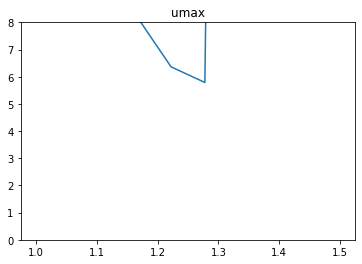

In [32]:
plot_score('umax', 1, 1.5, 10)

## Use pyswarm

In [33]:
import pyswarms as ps

In [34]:
Parameters = pd.read_csv('Parameters.csv', index_col=0)
para_values = Parameters.loc['Value',:].astype('float')
para_values.shape

(11,)

In [35]:
min_params = Parameters.loc['min',:].astype('float')
max_params = Parameters.loc['max',:].astype('float')
min_params.shape

(11,)

In [36]:
a = np.zeros((100,11))
a[1]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [37]:
def forswarm(swarm_para_values):
    n_particles = swarm_para_values.shape[0]
    print(swarm_para_values[0].shape)
    score = [sim_cal_nse(swarm_para_values[i]) for i in range(n_particles)]
    return np.array(score)

In [ ]:
swarm_size = 100
dim = 11
options = {'c1':0.5, 'c2':0.3, 'w':0.5}

constraints = (min_params.values, max_params.values)

optimizer = ps.single.GlobalBestPSO(n_particles = swarm_size,
                                   dimensions = dim,
                                   options = options,
                                   bounds = constraints)

cost, joint_vars = optimizer.optimize(forswarm, iters = 1000)

2021-04-11 11:35:03,818 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.5}
pyswarms.single.global_best:   0%|                                                                              |0/1000

(11,)


pyswarms.single.global_best:   0%|                                                              |1/1000, best_cost=6.54

(11,)


pyswarms.single.global_best:   0%|                                                              |2/1000, best_cost=5.74

(11,)


pyswarms.single.global_best:   0%|▏                                                             |3/1000, best_cost=5.74

(11,)


pyswarms.single.global_best:   0%|▏                                                             |4/1000, best_cost=5.37

(11,)


pyswarms.single.global_best:   0%|▎                                                             |5/1000, best_cost=5.37

(11,)
